<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Introduction to Source Detection</b> <br>
Contact author(s): Douglas Tucker, Alex Drlica-Wagner, Melissa Graham<br>
Last verified to run: 2022-06-23 <br>
LSST Science Piplines version: Weekly 2022_22 <br>
Container Size: medium <br>
Targeted learning level: beginner <br>

**Description:** Access, display, and manipulate images; detect, deblend, and measure sources; and extract, plot, and use object footprints.

**Skills:** 
After working through this notebook you should be able to run the `lsst.meas.algorithm` source detection, deblending, and measurement tasks; plot the resulting source catalogs on an image; and examine the `footprint` of the detected sources.  Other techniques that are demonstrated (but not emphasized) include the use of the `butler` to access a specific `calexp`, the creation of an image cutout; and the and use of `lsst.afw.display` to plot the image cutout.

**LSST Data Products:** Butler calexp images and mask planes.

**Packages:** 

Packages being taught: `lsst.pipe.tasks.characterizeImage`, `lsst.meas.algorithms.detection`, `lsst.meas.deblender`, `lsst.meas.base`

Supporting packages: `lsst.daf.base`, `lsst.daf.butler`, `lsst.afw.image`, `lsst.afw.display`, `lsst.afw.table`, `lsst.geom`

**Credit:**
Originally developed by Alex Drlica-Wagner and Imran Hasan in the context of the LSST Stack Club.  Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook provides a brief introduction to running the LSST Science Pipelines source detection, measurement, and deblending algorithms. It does not go into depth about optimizing detection, measurement, or deblending parameters for different types of sources. 

Some source detection and measurement details come from Robert Lupton's [Tune Detection.ipynb](https://github.com/RobertLuptonTheGood/notebooks/blob/master/Demos/Tune%20Detection.ipynb) and [Kron.ipynb](https://github.com/RobertLuptonTheGood/notebooks/blob/master/Demos/Kron.ipynb).
Interaction with `lsst.afw.display` was also improved by studying Michael Wood-Vasey's [DC2_Postage Stamps.ipynb](https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/dm_butler_postage_stamps.ipynb).
More information on footprints can be found on the Stack Club notebook by Imran Hasan [here](https://github.com/LSSTScienceCollaborations/StackClub/blob/master/SourceDetection/Footprints.ipynb).

### 1.1 Package Imports

The [`matplotlib`](https://matplotlib.org/) library is a widely used Python plot library. We also import the [`warnings`](https://docs.python.org/2/library/warnings.html) library to prevent some routine warning messages from printing to the screen.

We load the `lsst.afw.display` library to gain access to the image visualization routines we'd like to use, and the `lsst.daf.butler` library, which is used to access data products.  The `lsst.afw.image` and `lsst.afw.table` libraries provide handlers, respectively for the image and table outputs of the LSST Science Pipelines.  The `lsst.afw.geom` provide sky- and LSST-specific geometric routines. 

As we will see later, the `lsst.pipe.tasks.characterizeImage` library is used for characterizing properties of a given image (like PSF), the `lsst.meas.algorithms.detection` library provides methods for detecting sources within an image, the `lsst.meas.deblender` library gives methods for deblending sources into component parts ("children"), and the `lsst.meas.base` includes methods for measuring the properties of sources.

In [1]:
# General python packages
import warnings
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# LSST Science Pipeline packages (see pipelines.lsst.io)
import lsst.daf.base as dafBase
from lsst.daf.butler import Butler
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.geom as geom

# Pipeline tasks
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask

# matplotlib plot style
plt.style.use('tableau-colorblind10')

# Note: This will trigger a warning from CFITSIO in w_2022_22.
# This warning can be safely ignored and will be corrected in the future.

## 2. Some Additional Preliminaries

To suppress the output of some ancillary warning messages, we can issue the following commands from the `warnings` python module:

In [2]:
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)

Let us also set `lsst.afw.display` to use the `matplotlib` backend:

In [3]:
afwDisplay.setDefaultBackend('matplotlib')
plt.rcParams['figure.figsize'] = (8.0, 8.0)

What version of the Stack are we using?  This information is usually shown in the horizontal information 
bar at the bottown of an RSP notebook's window.  If not, one can also run the following command-line commands:

In [4]:
! echo $IMAGE_DESCRIPTION
! eups list -s | grep lsst_distrib

Recommended (Weekly 2022_22)
lsst_distrib          g0b29ad24fb+924bfe7984 	current w_2022_22 setup


## 3. Data Access


### 3.1 Access the `calexp` Data

Here we use the `butler` to access a `calexp` from the DP0.2 dataset. More information on the `butler` and `calexp`, 
and how to determine the `dataId` (e.g., the visit and detector numbers) are available in other tutorials. Here we 
start assuming that this information is known, and assuming a basic understanding of `butler` use.

First, let us define the configuration and collection and instantiate an instance of the butler.

In [5]:
# For DP0.2, we want the following configuration and collection:
configuration = "dp02"
collection = '2.2i/runs/DP0.2'

butler = Butler(config=configuration, collections=collection)

Let us look at the `calexp` data for `detector` 75 in `visit` 512055.

In [6]:
# Define the dataId using just visit and detector
dataId = {'visit': 512055, 'detector': 75}

# Use the butler to get the calexp
calexp = butler.get('calexp', **dataId)

<br>

As described in other tutorials, the `calexp` object possess more than just the raw pixel data of the image. It also contains a `mask`, which stores information about various pixels in a bit mask.

Here are some optional commands to explore the calexp. Uncomment one of the code lines to learn more.

In [7]:
# If you want to investigate the contents of the masked image:
# calexp.maskedImage

# If you just want one of the three components:
# calexp.maskedImage.image
# calexp.maskedImage.mask
# calexp.maskedImage.variance

# These also work:
# calexp.image
# calexp.mask
# calexp.variance

# The calexp also contains the PSF, the WCS, and the photometric calibration
# calexp.getPsf()
# calexp.getWcs()
# calexp.getPhotoCalib()

Since we are interested in performing our own source detection and measurement, we choose to clear the existing `DETECTED` mask plane.

In [8]:
# Unset the `DETECTED` bits of the mask plane
calexp.mask.removeAndClearMaskPlane('DETECTED')

<Figure size 432x288 with 0 Axes>

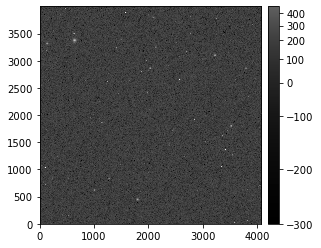

In [9]:
# Plot the calexp we just retrieved
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp.image)

<br>

### 3.2 Add the Subtracted Sky Background Back into the Image

Here we retrieve the subtracted background for the same dataId and add it back into the image. This section is optional.

First, we obtain the `calexpBackground` object for this `dataId`.  We will again use the `butler`.

In [10]:
bkgd = butler.get('calexpBackground', **dataId)

Now, let us display the background we obtained.

Text(0.5, 1.0, 'Local Polynomial Background')

<Figure size 432x288 with 0 Axes>

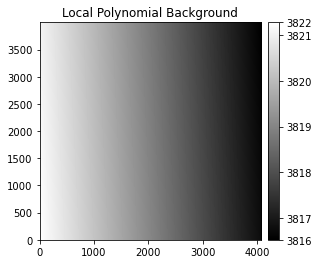

In [11]:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('linear', 'zscale')
afw_display.mtv(bkgd.getImage())
plt.title("Local Polynomial Background")

Next, we add the background into the `calexp`, and re-display the `calexp`. Note the scale in the sidebar now goes up to thousands of counts instead of hundreds of counts.

In [12]:
# Note: executing this cell multiple times will add the background
#  multiple times
calexp.maskedImage += bkgd.getImage()

<Figure size 432x288 with 0 Axes>

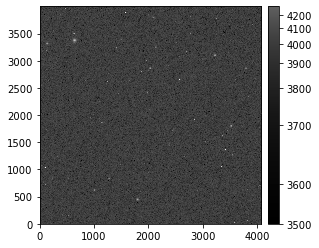

In [13]:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp.image)

### 3.3 Generate and Display a Smaller Cutout

Our next step is to generate a cutout image. This is done by creating a bounding box and passing it to the `Factory` method of our calexp (a `lsst.afw.image.Exposure` object). Below we explain the specific arguments that we are passing to `Factory`:
```
calexp : the ExposureF we are starting from
bbox   : the bounding box of the cutout
origin : the image pixel origin is local to the cutout array
deep   : copy the data rather than passing by reference
```

In [14]:
# Define the pixel coordinates of a known low surface brightness "galaxy"
x_target, y_target = 1700, 2100
width, height = 400, 400
xmin, ymin = x_target-width//2, y_target-height//2
point = geom.Point2D(x_target, y_target)

# Define a small region for a cutout
bbox = geom.Box2I()
bbox.include(geom.Point2I(xmin, ymin))
bbox.include(geom.Point2I(xmin + width, ymin + height))

# An alternative way to defined the same cutout region
# bbox = geom.Box2I(geom.Point2I(xmin, ymin), geom.Extent2I(width, height))

# Generate the cutout image
cutout = calexp.Factory(calexp, bbox, origin=afwImage.LOCAL, deep=False)

(1499.5, 1900.5, 1899.5, 2300.5)

<Figure size 432x288 with 0 Axes>

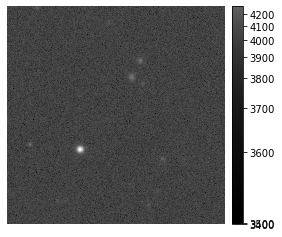

In [15]:
# Follow the same procedure as before to plot the cutout
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(cutout.image)
plt.gca().axis('off')

## 4. Source Detection, Deblending, and Measurement

We now want to run the LSST Science Pipelines' source detection, deblending, and measurement tasks. While we run all three tasks, this notebook is mostly focused on the detection of sources.

Recall that these tasks were imported up at the top of this notebook, from `lsst.pipe` and `lsst.meas`. More information can be found at [pipelines.lsst.io](https://pipelines.lsst.io/) (the search bar at the top left of that page is a very handy way to find documentation for a specific task).

We start by creating a minimal schema for the source table. The schema describes the output properties that will be measured for each source. This schema will be passed to all of the tasks, as we call each in turn, and each task will add columns to this schema as it measures sources in the image.

In [16]:
# Create a basic schema to use with these tasks
schema = afwTable.SourceTable.makeMinimalSchema()
print(schema)

# Create a container which will be used to record metadata
#  about algorithm execution
algMetadata = dafBase.PropertyList()
print('algMetadata: ')
algMetadata

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
)

algMetadata: 


### 4.1 Configuring Tasks

Each task possesses an associated configuration class. The properties of these configuration classes can be determined from the classes themselves.

In [17]:
# Uncomment the following line to view help
#  for the CharacterizeImageTask configuration
# Replace 'CharacterizeImageTask' with a different
#  task name to view additional help information

# help(CharacterizeImageTask.ConfigClass())

As a starting point, like the `schema` and `algMetadata` above, here we set some basic config parameters and instantiate the tasks to get you started. In this case, we configure several different tasks:

* CharacterizeImageTask: Characterizes the image properties (e.g., PSF, etc.)
* SourceDetectionTask: Detects sources
* SourceDeblendTask: Deblend sources into constituent children
* SingleFrameMeasurementTask: Measures source properties

In [18]:
# Characterize the image properties
config = CharacterizeImageTask.ConfigClass()
config.psfIterations = 1
charImageTask = CharacterizeImageTask(config=config)

# Detect sources
config = SourceDetectionTask.ConfigClass()
# detection threshold in units of thresholdType
config.thresholdValue = 10
# units for thresholdValue
config.thresholdType = "stdev"
sourceDetectionTask = SourceDetectionTask(schema=schema, config=config)

# Deblend sources
sourceDeblendTask = SourceDeblendTask(schema=schema)

# Measure source properties
config = SingleFrameMeasurementTask.ConfigClass()
sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema,
                                                   config=config,
                                                   algMetadata=algMetadata)

Note that if you want to change the value of a config parameter (e.g., `psfIterations`), do not change it in the already constructed task. Instead, change your config object and then construct a new characterize image task. Like so:
> `config.psfIterations = 3` <br>
> `charImageTask = CharacterizeImageTask(config=config)`

Like the configs, we can use `help` to explore each task and the methods used to run it.

In [19]:
# help(charImageTask)

# Uncomment the following line, position your cursor after the period,
#  and press tab to see a list of all methods. Then recomment the line
#  because "Task." is not executable and will cause an error.
# charImageTask.

# Use the help function on any of the methods to learn more:
# help(charImageTask.writeSchemas)

# E.g., find out what options there are for config.thresholdType
# help(SourceDetectionTask.ConfigClass)

With the each of the tasks configured, we can now move on to running the source detection, deblending, and measurement. First we create `SourceTable` for holding the output of our source analysis. The columns and characteristics of this table are defined by the `schema` that we created in our configuration step.

In [20]:
tab = afwTable.SourceTable.make(schema)

### 4.2 Image Characterization

Next we characterize our image. This calculates various global properties of the image, such as the full-width half-max of its point spread function (PSF FWHM).

In [21]:
# Image characterization (this cell may take a few seconds)
result = charImageTask.run(calexp)

# Get the PSF at our point of interest
psf = calexp.getPsf()
sigma = psf.computeShape(point).getDeterminantRadius()
pixelScale = calexp.getWcs().getPixelScale().asArcseconds()

# # The factor of 2.355 converts from std to fwhm
# print('psf fwhm = {:.2f} arcsec'.format(sigma*pixelScale*2.355))

With the image characterized, we are now interested in running the source detection, deblending, and measurement tasks. Each of these tasks is called with the `run` method. The parameters of this method can be investigated using `help`.

In [22]:
# We are specifically interested in the `SourceMeasurementTask`
# help(sourceMeasurementTask.run)

In [23]:
# Source detection (this cell may take a few seconds)
result = sourceDetectionTask.run(tab, calexp)
type(result)

lsst.pipe.base.struct.Struct

The source detection task returns an [`lsst.pipe.base.struct.Struct`](http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/classlsst_1_1pipe_1_1base_1_1struct_1_1_struct.html). A `Struct` is just a generalized container for storing multiple output components and accessessing them as attributes. The content of this `Struct` can be investigated with the `getDict` method.

In [24]:
for k, v in result.getDict().items():
    print(k, type(v))

positive <class 'lsst.afw.detection.FootprintSet'>
negative <class 'NoneType'>
factor <class 'float'>
positiveThreshold <class 'lsst.afw.detection.Threshold'>
negativeThreshold <class 'lsst.afw.detection.Threshold'>
background <class 'lsst.afw.math._backgroundList.BackgroundList'>
numPos <class 'int'>
numPosPeaks <class 'int'>
numNeg <class 'int'>
numNegPeaks <class 'int'>
fpSets <class 'lsst.pipe.base.struct.Struct'>
sources <class 'lsst.afw.table.SourceCatalog'>


In [25]:
result.numPosPeaks

940

When we use `config.thresholdValue = 10` we get 940 positive peaks. If we rerun with `config.thresholdValue = 3` we would find 5336 positive peaks.

In [26]:
sources = result.sources

Most of the columns for sources will be NaN at first.

In [27]:
# Uncomment to see that most values are NaN
# sources

Note that if we desire we can save some of these processed objects to disk as FITS tables.

In [28]:
# sources.writeFits("outputTable.fits")
# calexp.writeFits("example1-out.fits")

### 4.3 Deblend and Measure Sources

Next we run the `SourceDeblendTask` and `SingleFrameMeasurementTask`. A deeper investigation of these tasks is beyond the scope of this notebook.

In [29]:
# Source deblending
sourceDeblendTask.run(calexp, sources)

# Source measurement (catch future warning about machine precision)
sourceMeasurementTask.run(measCat=sources, exposure=calexp)

To get a better look at the output sources, we need to make sure that the `SourceCatalog` is contiguous in memory. Converting to an `astropy` table provides a human-readable output format. A deeper dive into `SourceCatalog` is beyond the scope of this notebook.

In [30]:
# The copy makes sure that the sources are sequential in memory
sources = sources.copy(True)

# Investigate the output source catalog
sources.asAstropy()

id,coord_ra,coord_dec,parent,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psf_instFlux,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_skipped,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux,deblend_peak_center_x,deblend_peak_center_y,deblend_peakId,deblend_nPeaks,deblend_parentNPeaks,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_LocalBackground_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_LocalBackground_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,slot_Centroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_CircularApertureFlux_flag_badCentroid_resetToPeak,base_GaussianFlux_flag_badCentroid_resetToPeak,base_LocalBackground_flag_badCentroid_resetToPeak,base_NaiveCentroid_flag_badInitialCentroid_resetToPeak,base_PsfFlux_flag_badCentroid_resetToPeak,base_SdssShape_flag_badCentroid_resetToPeak,base_Variance_flag_badCentroid_resetToPeak,slot_Centroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_CircularApertureFlux_flag_badCentroid_badError,base_GaussianFlux_flag_badCentroid_badError,base_LocalBackground_flag_badCentroid_badError,base_NaiveCentroid_flag_badInitialCentroid_badError,base_PsfFlux_flag_badCentroid_badError,base_SdssShape_flag_badCentroid_badError,base_Variance_flag_badCentroid_badError,slot_Centroid_flag_badError,base_Blendedness_old,base_Blendedness_raw,base_Blendedness_raw_child_instFlux,base_Blendedness_raw_parent_instFlux,base_Blendedness_abs,base_Blendedness_abs_child_instFlux,base_Blendedness_abs_parent_instFlux,base_Blendedness_raw_child_xx,base_Blendedness_raw_child_yy,base_Blendedness_raw_child_xy,base_Blendedness_raw_parent_xx,base_Blendedness_raw_parent_yy,base_Blendedness_raw_parent_xy,base_Blendedness_abs_child_xx,base_Blendedness_abs_child_yy,base_Blendedness_abs_child_xy,base_Blendedness_abs_parent_x

### 4.4 Overplot Sources on Image

We can now overplot our detected sources on the calexp or cutout image using `afwDisplay`.

<a id='display-error'></a>

<Figure size 432x288 with 0 Axes>

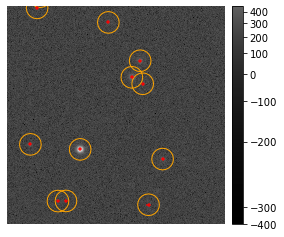

In [31]:
# Display the cutout and sources with afw display
image = cutout.image

plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(image)
plt.gca().axis('off')

# We use display buffering to avoid re-drawing the image
#  after each source is plotted
with afw_display.Buffering():
    for s in sources:
        afw_display.dot('+', s.getX(), s.getY(), ctype=afwDisplay.RED)
        afw_display.dot('o', s.getX(), s.getY(), size=20, ctype='orange')

## 5. Footprints

Object footprints are an integral component of the high-level CCD processing tasks (e.g., detection, measurement, and deblending). To quote [Bosch et al. (2017)](https://arxiv.org/pdf/1705.06766.pdf), 

> Footprints record the exact above-threshold detection region on a CCD. These are similar to  SExtractor’s “segmentation map", in that they identify which pixels belong to which detected objects

This quote draws an analogy between footprints and segmentation maps, since they both identify pixels with values above some threshold. This is a useful similarity, since it gives us a place to start understanding the properties of footprints.

The result of the `SourceDetectionTask` stores the footprints associated to detected objects

In [32]:
# Grab the above-threshold footprints that were detected,
#  and assign them to the variable `fps`
fpset = result.positive
fps = fpset.getFootprints()

In [33]:
# We can get a rough view of the first source's footprint from its span
fps[0].getSpans()

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1

You can almost see the footprint by looking at the 1's and 0's here. Keep in mind that the first row of this array will be the *bottom* row of the image. Later, when we display the footprint, its general pattern will appear "upside down" compared to this pattern of 1s. 

### 5.1 Heavy Footprints

At the moment, our footprints indicate which pixels they consist of, but not the values of those pixels from the image. To extract the actual values of the pixels that correspond to the ones in the footprint span, we need to convert our footprint into a `HeavyFootprint`. HeavyFootprints have all of the qualities of Footprints, but additionally 'know' about pixel level data from the image, variance, and mask planes.

In [34]:
# First we demonstrate that the footprint is NOT heavy
fps[0].isHeavy()

False

In [35]:
# Next, we make all the footprints heavy at the same time
#  by operating on the footprint set
fpset.makeHeavy(calexp.getMaskedImage())

# This means we have to redefine fps:
hfps = fpset.getFootprints()

In [36]:
# All of the arrays here will be flattend 1D arrays
#  of pixels from the footprint.
# Uncomment this line to print the array and see that
#  now, it contains pixel values.

# hfps[0].getImageArray()

Now we can use the span set to reassemble the image array into the footprint. Above we saw that the image array is a 1D numpy array, but the footprint itself is 2 dimensional. Fortunately, the span set has an `unflatten` method that rearranges the image array into the proper 2 dimensional shape. If you want to change the colormap, see [matplotlib colormap options](https://matplotlib.org/stable/tutorials/colors/colormaps.html).

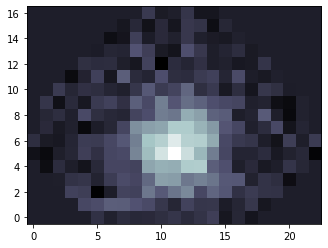

In [37]:
plt.figure()
plt.imshow(fps[0].getSpans().unflatten(hfps[0].getImageArray()),
           cmap='bone', origin='lower')

The heavy footprint also comes with a 1d mask array.

In [38]:
hfps[0].getMaskArray()

array([48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
       48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
       48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
       48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
       48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
       48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
       48, 48, 48, 48, 48, 48, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32

In [39]:
calexp.getMask().getMaskPlaneDict()

{'BAD': 0,
 'CR': 3,
 'CROSSTALK': 9,
 'DETECTED': 5,
 'DETECTED_NEGATIVE': 6,
 'EDGE': 4,
 'INTRP': 2,
 'NOT_DEBLENDED': 10,
 'NO_DATA': 8,
 'SAT': 1,
 'SUSPECT': 7,
 'UNMASKEDNAN': 11}

The values are the exponent of the bitmask. So pixels only marked detected will be 2^5 = 32. Pixels that are both on the edge of the original image and detected will be 2^5 + 2^4 = 48. We will visualize the mask plane values in a similar manner as before, except that we will be displaying the values of the mask array.

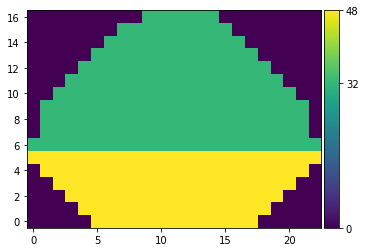

In [40]:
plt.figure()
im = plt.imshow(fps[0].getSpans().unflatten(hfps[0].getMaskArray()),
                origin='lower')

# Create a new axis, "cax" on the right side of the image display.
# The width of cax will be 5% of the axis "ax".
# The padding between cax and ax will be 1% of the axis.
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad="1%")
plt.colorbar(im, cax=cax, ticks=[0, 32, 32+16])